# Imports

In [13]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playbyplay,leaguegamefinder,leaguedashteamstats
from nba_api.stats.static import teams
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from tqdm.notebook import tqdm
pd.options.display.max_columns = None
from scipy import stats
import statsmodels.api as sm
from fitter import Fitter
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score


In [2]:
# Define a helper function to handle coalesce logic
def coalesce(*args):
    return next((arg for arg in args if pd.notnull(arg)), np.nan)

# Define a helper function to get the last non-NaN value
def last_non_nan(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else np.nan
# Define the getmode function
def getmode(x):
    uniqx, counts = np.unique(x, return_counts=True)
    return uniqx[np.argmax(counts)]

# Helper function to find first occurrence index
def first_occurrence(series):
    return (series.index[0] if series.any() else np.inf)

# Define a function to determine the first timeout used during a run
def first_timeout(x, timeout_col):
    timeouts = x[x[timeout_col]].index  # Get indices where timeout is True
    return timeouts[0] if not timeouts.empty else np.inf

# Define a function to determine period change within a run
def period_change(x):
    changes = x.index[x.shift(-1) != x]  # Get indices where period changes
    return changes[0] if not changes.empty else np.inf

# Preparation

In [3]:
SEASON_START = '2023-10-24'

In [4]:
teams_ids = [x['id'] for x in teams.get_teams()]

In [7]:
games = leaguegamefinder.LeagueGameFinder(team_id_nullable=teams_ids[0]).get_data_frames()[0]

In [12]:
games['SEASON_ID'].str[-4:]

0       2023
1       2023
2       2023
3       2023
4       2023
        ... 
3691    1983
3692    1983
3693    1983
3694    1983
3695    1983
Name: SEASON_ID, Length: 3696, dtype: object

In [4]:
all_games = []
for team in teams_ids:
    games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team).get_data_frames()[0]
    games = games[games['SEASON_ID'].astype(str).str.endswith('2023')]
    games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
    games = games[games['GAME_DATE']>=SEASON_START]
    all_games.extend(games['GAME_ID'].to_list())

In [5]:
all_games = list(set(all_games))

In [ ]:
# #df = pd.DataFrame()
# for game in tqdm_notebook(all_games):
#     if game in df['GAME_ID'].unique():
#         continue
#     else:
#         pbp = playbyplay.PlayByPlay(game_id=game).get_data_frames()[0]
#         df = pd.concat([df,pbp],ignore_index=True)
#         sleep(2)
# df.to_pickle('pbp_2023-24.pkl')

In [679]:
df = pd.read_pickle('pbp_2023-24.pkl')

In [680]:
# Define keywords for turnovers
turnover_keywords = ['BLOCK', 'STEAL']

# Function to determine possession
def determine_possession(row):
    if row['VISITORDESCRIPTION'] and row['HOMEDESCRIPTION']:
        # If both descriptions are present, determine possession based on turnover keywords
        if any(keyword in row['VISITORDESCRIPTION'] for keyword in turnover_keywords):
            return row['HomeName']
        elif any(keyword in row['HOMEDESCRIPTION'] for keyword in turnover_keywords):
            return row['AwayName']
    # Default case where only one of the descriptions is present
    return row['AwayName'] if row['VISITORDESCRIPTION'] else row['HomeName']

In [681]:
first_timeout_seconds = 6 * 60 + 59
second_timeout_seconds = 2 * 60 + 59

In [198]:
# Load the dataset
pbp_raw = df.copy()

# Turn play-by-play data into possessions
pbp = pbp_raw.copy()
# pbp['date'] = pd.to_datetime(pbp['Date'], format="%m/%d/%Y")
# pbp['month'] = pbp['date'].dt.month
# pbp['day'] = pbp['date'].dt.day
# pbp['year'] = pbp['date'].dt.year

# Convert game clock display to seconds remaining
pbp['qtr_seconds_remaining'] = pbp['PCTIMESTRING'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
pbp['AwayName'] = ''
pbp['HomeName'] = ''
for game in pbp['GAME_ID'].unique():
    pbp.loc[pbp['GAME_ID']==game,'AwayName'] = pbp[(pbp['EVENTMSGTYPE']==9)&(pbp['GAME_ID']==game)]['VISITORDESCRIPTION'].str.split(' ',expand=True)[0].value_counts().index[0].capitalize()
    pbp.loc[pbp['GAME_ID']==game,'HomeName'] = pbp[(pbp['EVENTMSGTYPE']==9)&(pbp['GAME_ID']==game)]['HOMEDESCRIPTION'].str.split(' ',expand=True)[0].value_counts().index[0].capitalize()
# Data formatted so that events attributed to possessing team
# Remove non-action events
pbp = pbp[(pbp['NEUTRALDESCRIPTION'].isnull())]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("FOUL")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("FOUL")]
# Note upcoming timeouts before removing them
pbp['home_timeout_after'] = pbp['HOMEDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp['away_timeout_after'] = pbp['VISITORDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("Timeout") & ~pbp['HOMEDESCRIPTION'].fillna('').str.contains("Timeout")]
pbp['possession'] = pbp.apply(determine_possession, axis=1)

# # Group by GameID and possession
pbp['possession'] = pbp.groupby(['GAME_ID', 'possession'])['possession'].transform(getmode)

# # Assign key column to clusters of data
pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum())
pbp[['VISITORSCORE','HOMESCORE']] = pbp['SCORE'].str.split('-',expand=True)
pbp['HOMESCORE'] = pbp['HOMESCORE'].astype(str).str.replace('None','NaN').astype(float)
pbp['VISITORSCORE'] = pbp['VISITORSCORE'].astype(str).str.replace('None','NaN').astype(float)
# pbp['HOMESCORE'].fillna(method='ffill',inplace=True)
# pbp['VISITORSCORE'].fillna(method='ffill',inplace=True)
pbp['coalesce_event'] = pbp.apply(lambda row: coalesce(row['VISITORDESCRIPTION'], row['HOMEDESCRIPTION']), axis=1)
# # Summary info for each possession

# Group by the relevant columns and summarize each possession
possession_summary = pbp.groupby(['GAME_ID', 'PERIOD', 'HomeName', 'AwayName', 'possession_id','possession']).agg(
    start=('qtr_seconds_remaining', 'min'),
    end=('qtr_seconds_remaining', 'max'),
    end_home_score=('HOMESCORE', 'max'),
    end_away_score=('VISITORSCORE', 'max'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.value_counts() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.value_counts() else False),
    last_event=('coalesce_event', 'last'),
).reset_index()
possession_summary['end_home_score'].fillna(0,inplace=True)
possession_summary['end_away_score'].fillna(0,inplace=True)

# Keep track of score
possession_summary['score'] = np.where(possession_summary['possession'] == possession_summary['HomeName'],
                                       possession_summary['end_home_score'] > possession_summary['end_home_score'].shift(),
                                       possession_summary['end_away_score'] > possession_summary['end_away_score'].shift())
possession_summary['last_score'] = np.where(possession_summary['score'], possession_summary['possession'], np.nan)

# Keep track of who scored last
possession_summary['last_score'] = possession_summary['last_score'].ffill()
possession_summary['last_score'] = possession_summary['last_score'].shift()

# Team identities required for matchup modeling
possession_summary['home_poss'] = possession_summary['possession'] == possession_summary['HomeName']
possession_summary['offense'] = np.where(possession_summary['home_poss'], possession_summary['HomeName'], possession_summary['AwayName'])
possession_summary['defense'] = np.where(possession_summary['home_poss'], possession_summary['AwayName'], possession_summary['HomeName'])
possession_summary['gp'] = possession_summary['GAME_ID'].astype(str) + possession_summary['PERIOD'].astype(str)

C:\Users\isaac\AppData\Local\Temp\ipykernel_14960\480830038.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum())


In [199]:
possession_summary.to_pickle('possession_summary_2023-24.pkl')

In [269]:
possession_summary = pd.read_pickle('possession_summary_2023-24.pkl')

In [270]:
possession_summary = possession_summary[(possession_summary['end_home_score']>0)|(possession_summary['end_away_score']>0)]

In [271]:
runs = possession_summary.copy()

In [272]:
runs['run_id'] = (runs.groupby(['GAME_ID','score'])['offense'].apply(lambda x: (x != x.shift()).cumsum()) + 1).values
runs['run_id_gp'] = ((runs.groupby(['gp','score'])['offense'].apply(lambda x: (x != x.shift()).cumsum()))+1).values

In [219]:

# Aggregate possession info over runs (game)
runs_agg = runs.groupby(['GAME_ID',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    timeout=('home_poss', lambda x: first_timeout(runs.loc[x.index], 'away_timeout_after') if x.iloc[0] else first_timeout(runs.loc[x.index], 'home_timeout_after')),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last')
).reset_index()

# Aggregate possession info over runs (game-period)
runs_agg_gp = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    timeout=('home_poss', lambda x: first_timeout(runs.loc[x.index], 'away_timeout_after') if x.iloc[0] else first_timeout(runs.loc[x.index], 'home_timeout_after')),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last')
).reset_index()


In [49]:
runs_agg_gp.to_pickle('runs_agg_gp_2023-24.pkl')
runs_agg.to_pickle('runs_agg_2023-24.pkl')

# EDA

In [17]:
runs_agg_gp = pd.read_pickle('runs_agg_gp_2023-24.pkl')
runs_agg = pd.read_pickle('runs_agg_2023-24.pkl')

<Axes: xlabel='timeout'>

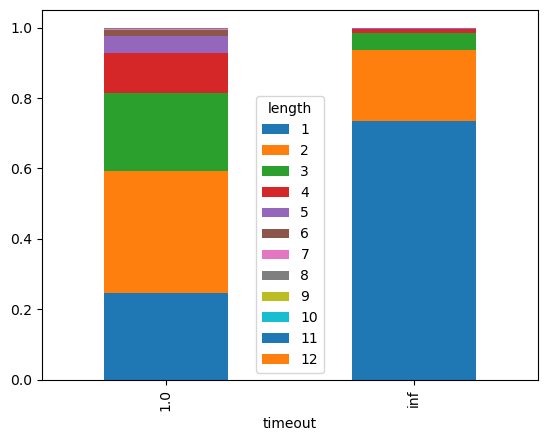

In [9]:
runs_agg_gp.groupby('timeout')['length'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True)

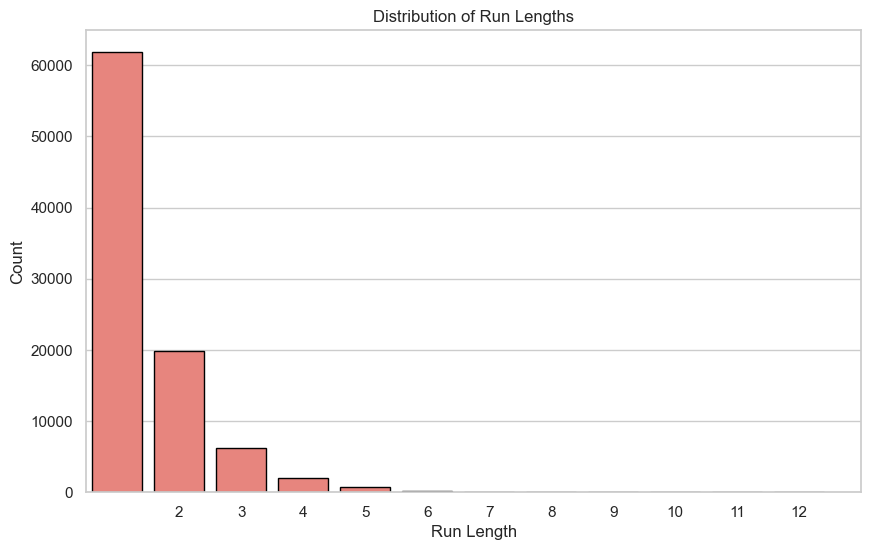

In [52]:
# Set the figure size for better clarity
plt.figure(figsize=(10, 6))

# Plot the data using seaborn's countplot
sns.countplot(data=runs_agg_gp, x='length', color='#F8766D', edgecolor='black')

# Set the breaks for x-axis
max_length = runs_agg_gp['length'].max()
plt.xticks(ticks=range(1, max_length + 1))

# Apply a theme similar to theme_bw in ggplot2
sns.set_theme(style="whitegrid")

# Adding labels
plt.xlabel("Run Length")
plt.ylabel("Count")

# Show the plot
plt.title("Distribution of Run Lengths")
plt.show()

In [273]:
runs.reset_index(inplace=True,drop=True)
runs['to_start'] = runs['start'] - 1

In [145]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [203]:
#test = test[((test['away_timeout_after']==True)&(test['home_timeout_after']==False))|((test['away_timeout_after']==False)&(test['home_timeout_after']==True))]

In [206]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [274]:
dict_all_runs = {
    'run_id_gp': [],
    'gp': [],
    'home_team': [],
    'away_team': [],
    'home_score': [],
    'away_score': [],
    'run_length': [],
    'to': [],
    'home_to': [],
    'away_to': [],
    'to_index': [],
    'changed_run': [],
    'run_team': [],
    'next_run_length': [],
    'next_run_home_score': [],
    'next_run_away_score': [],
    'next_run_team': [],
    'previous_run_length': [],
    'previous_run_home_score': [],
    'previous_run_away_score': [],
    'previous_run_team': [],
    'avg_opponent_run_length': [],
    'opponent_run_length_max': [],
    'opponent_run_length_min': [],
    'avg_own_run_length': [],
    'own_run_length_max': [],
    'own_run_length_min': [],
    'to_team': []
}

for ix, group in runs.head(29).groupby(['gp', 'run_id_gp']):
    run_id = group['run_id_gp'].iloc[0]
    gp = group['gp'].iloc[0]
    home_team = group['HomeName'].iloc[0]
    away_team = group['AwayName'].iloc[0]
    home_score = group['end_home_score'].iloc[-1]
    away_score = group['end_away_score'].iloc[-1]
    run_length = group.shape[0]
    run_team = group['offense'].iloc[0]
    previous_run_team = group['defense'].iloc[0]
    gp_int = int(gp)
    # Calculate timeouts and run changes
    if True in group['home_timeout_after'].values:
        to = 1
        home_to = 1
        away_to = 0
        to_list = group['home_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'home'
    elif True in group['away_timeout_after'].values:
        to = 1
        home_to = 0
        away_to = 1
        to_list = group['away_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'away'
    else:
        to, home_to, away_to, true_index, changed_run = 0, 0, 0, 0, 0
        timeout = np.nan

    # Find next and previous runs within the same game-period (gp)
    next_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id + 1)]
    prev_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id - 1)]

    if not next_run.empty:
        next_run_length = next_run.shape[0]
        next_run_home_score = next_run['end_home_score'].iloc[-1]
        next_run_away_score = next_run['end_away_score'].iloc[-1]
        next_run_team = next_run['offense'].iloc[0]
    else:
        try:
            next_gp = str(gp_int + 1).zfill(11)
            next_run = runs[(runs['gp'] == next_gp)]
            next_run = next_run[next_run['run_id_gp'] == next_run['run_id_gp'].min()]
            next_run_length = next_run.shape[0]
            next_run_home_score = next_run['end_home_score'].iloc[-1]
            next_run_away_score = next_run['end_away_score'].iloc[-1]
            next_run_team = next_run['offense'].iloc[0]
        except:
            next_run_length, next_run_home_score, next_run_away_score, next_run_team = 0, 0, 0, np.nan

    if not prev_run.empty:
        previous_run_length = prev_run.shape[0]
        previous_run_home_score = prev_run['end_home_score'].iloc[-1]
        previous_run_away_score = prev_run['end_away_score'].iloc[-1]
        previous_run_team = prev_run['offense'].iloc[0]
    else:
        try:
            prev_gp = str(gp_int - 1).zfill(11)
            previous_run = runs[(runs['gp'] == prev_gp)]
            previous_run = previous_run[previous_run['run_id_gp'] == previous_run['run_id_gp'].max()]
            previous_run_length = previous_run.shape[0]
            previous_run_home_score = previous_run['end_home_score'].iloc[-1]
            previous_run_away_score = previous_run['end_away_score'].iloc[-1]
            previous_run_team = previous_run['offense'].iloc[0]
        except:
            previous_run_length, previous_run_home_score, previous_run_away_score, previous_run_team = 0, 0, 0, np.nan
    previous_5_runs_own = [run_id-i for i in range(2, 14,2)]
    previous_5_runs_opponent = [run_id-i for i in range(1, 12,2)]
    # Get the previous 5 runs by the same team and opponent
    prev_own_runs = runs[(runs['gp'] == gp) & (runs['offense'] == run_team) & (runs['run_id_gp'].isin(previous_5_runs_own))]
    prev_opponent_runs = runs[(runs['gp'] == gp) & (runs['offense'] != run_team) & (runs['run_id_gp'].isin(previous_5_runs_opponent))]

    if not prev_own_runs.empty:
        avg_own_run_length = (prev_own_runs.groupby('run_id_gp').size()).mean()
        own_run_length_max = (prev_own_runs.groupby('run_id_gp').size()).max()
        own_run_length_min = (prev_own_runs.groupby('run_id_gp').size()).min()
    else:
        avg_own_run_length, own_run_length_max, own_run_length_min = None, None, None

    if not prev_opponent_runs.empty:
        avg_opponent_run_length = (prev_opponent_runs.groupby('run_id_gp').size()).mean()
        opponent_run_length_max = (prev_opponent_runs.groupby('run_id_gp').size()).max()
        opponent_run_length_min = (prev_opponent_runs.groupby('run_id_gp').size()).min()
    else:
        avg_opponent_run_length, opponent_run_length_max, opponent_run_length_min = None, None, None
    if timeout == 'home':
        to_team = home_team
    elif timeout == 'away':
        to_team = away_team
    else:
        to_team = np.nan
    # Append values to the dictionary during your analysis
    dict_all_runs['run_id_gp'].append(run_id)
    dict_all_runs['gp'].append(gp)
    dict_all_runs['home_team'].append(home_team)
    dict_all_runs['away_team'].append(away_team)
    dict_all_runs['home_score'].append(home_score)
    dict_all_runs['away_score'].append(away_score)
    dict_all_runs['run_team'].append(run_team)
    dict_all_runs['run_length'].append(run_length)
    dict_all_runs['to'].append(to)
    dict_all_runs['home_to'].append(home_to)
    dict_all_runs['away_to'].append(away_to)
    dict_all_runs['to_index'].append(true_index)
    dict_all_runs['changed_run'].append(changed_run)
    dict_all_runs['next_run_length'].append(next_run_length)
    dict_all_runs['next_run_home_score'].append(next_run_home_score)
    dict_all_runs['next_run_away_score'].append(next_run_away_score)
    dict_all_runs['next_run_team'].append(next_run_team)
    dict_all_runs['previous_run_length'].append(previous_run_length)
    dict_all_runs['previous_run_home_score'].append(previous_run_home_score)
    dict_all_runs['previous_run_away_score'].append(previous_run_away_score)
    dict_all_runs['previous_run_team'].append(previous_run_team)
    dict_all_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_all_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_all_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_all_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_all_runs['own_run_length_max'].append(own_run_length_max)
    dict_all_runs['own_run_length_min'].append(own_run_length_min)
    dict_all_runs['to_team'].append(to_team)

In [275]:
df_as = pd.DataFrame(dict_all_runs)

In [276]:
df_as

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team
0,2,00223000011,Pacers,Cavaliers,5.0,0.0,2,0,0,0,0,0,Pacers,2,5.0,5.0,Cavaliers,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,00223000011,Pacers,Cavaliers,5.0,5.0,2,0,0,0,0,0,Cavaliers,3,12.0,5.0,Pacers,2,5.0,0.0,Pacers,2.000000,2.0,2.0,NaN,NaN,NaN,NaN
2,4,00223000011,Pacers,Cavaliers,12.0,5.0,3,0,0,0,0,0,Pacers,1,12.0,7.0,Cavaliers,2,5.0,5.0,Cavaliers,2.000000,2.0,2.0,2.000000,2.0,2.0,NaN
3,5,00223000011,Pacers,Cavaliers,12.0,7.0,1,0,0,0,0,0,Cavaliers,1,15.0,7.0,Pacers,3,12.0,5.0,Pacers,2.500000,3.0,2.0,2.000000,2.0,2.0,NaN
4,6,00223000011,Pacers,Cavaliers,15.0,7.0,1,0,0,0,0,0,Pacers,1,15.0,9.0,Cavaliers,1,12.0,7.0,Cavaliers,1.500000,2.0,1.0,2.500000,3.0,2.0,NaN
5,7,00223000011,Pacers,Cavaliers,15.0,9.0,1,0,0,0,0,0,Cavaliers,1,17.0,9.0,Pacers,1,15.0,7.0,Pacers,2.000000,3.0,1.0,1.500000,2.0,1.0,NaN
6,8,00223000011,Pacers,Cavaliers,17.0,9.0,1,1,0,1,0,1,Pacers,1,17.0,11.0,Cavaliers,1,15.0,9.0,Cavaliers,1.333333,2.0,1.0,2.000000,3.0,1.0,Cavaliers
7,9,00223000011,Pacers,Cavaliers,17.0,11.0,1,0,0,0,0,0,Cavaliers,1,20.0,11.0,Pacers,1,17.0,9.0,Pacers,1.750000,3.0,1.0,1.333333,2.0,1.0,NaN
8,10,00223000011,Pacers,Cavaliers,20.0,11.0,1,0,0,0,0,0,Pacers,1,20.0,13.0,Cavaliers,1,17.0,11.0,Cavaliers,1.250000,2.0,1.0,1.750000,3.0,1.0,NaN
9,11,00223000011,Pacers,Cavaliers,20.0,13.0,1,0,0,0,0,0,Cavaliers,1,22.0,13.0,Pacers,1,20.0,11.0,Pacers,1.600000,3.0,1.0,1.250000,2.0,1.0,NaN


In [259]:
df_as['net_diff'] = (df_as['home_score'] - df_as['previous_run_home_score']) - (df_as['away_score'] - df_as['previous_run_away_score'])

In [197]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [195]:
#test = test[((test['away_timeout_after']==True)&(test['home_timeout_after']==False))|((test['away_timeout_after']==False)&(test['home_timeout_after']==True))]

In [198]:
test

,gp,run_id_gp,offense,defense,home_poss,length,home_timeout_after,away_timeout_after,start_period,period_change,home_score,away_score,home_team,away_team
0,00223000011,2,Pacers,Cavaliers,True,2,False,False,1,1,5.0,0.0,Pacers,Cavaliers
1,00223000011,3,Cavaliers,Pacers,False,2,False,False,1,3,5.0,5.0,Pacers,Cavaliers
2,00223000011,4,Pacers,Cavaliers,True,3,False,False,1,6,12.0,5.0,Pacers,Cavaliers
3,00223000011,5,Cavaliers,Pacers,False,1,False,False,1,7,12.0,7.0,Pacers,Cavaliers
4,00223000011,6,Pacers,Cavaliers,True,1,False,False,1,8,15.0,7.0,Pacers,Cavaliers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90933,00623000014,17,Pacers,Lakers,False,1,False,False,4,133756,118.0,106.0,Lakers,Pacers
90934,00623000014,18,Lakers,Pacers,True,1,False,False,4,133757,121.0,106.0,Lakers,Pacers
90935,00623000014,19,Pacers,Lakers,False,1,False,False,4,133758,121.0,108.0,Lakers,Pacers
90936,00623000014,20,Lakers,Pacers,True,1,False,False,4,133759,123.0,108.0,Lakers,Pacers


In [204]:
dict_runs ={'run_id_gp':[],
            'home_team':[],'away_team':[],
            'gp':[],'to_team':[],'timeout':[],
            'net_diff':[],'opponent_run_length':[],
            'avg_opponent_run_length':[],'opponent_run_length_max':[],
            'opponent_run_length_min':[],'own_run_length':[],
            'avg_own_run_length':[],'own_run_length_max':[],
            'own_run_length_min':[],'previous_opp_run':[],'previous_opp_run_length':[]}
for ix in tqdm(test[(test['run_id_gp']<=13) & (test['gp']=='00223000011')].index):
    run_id = test.loc[ix,'run_id_gp']
    home_to = test.loc[ix,'home_timeout_after']
    away_to = test.loc[ix,'away_timeout_after']
    gp = test.loc[ix,'gp']
    if home_to == True:
        to_team = test.loc[ix,'home_team']
        timeout = 'home'
    else:
        to_team = test.loc[ix,'away_team']
        timeout = 'away'
    
    run_df = test.loc[(test['run_id_gp']<=run_id)&(test['gp']==gp)&((test['away_timeout_after']==False)|(test['home_timeout_after']==False))]
    other_team_runs = run_df[(run_df['offense']!=to_team)].iloc[-5:]
    to_team_runs = run_df[(run_df['offense']==to_team)].iloc[-5:]
    if timeout == 'home':
        try:
            net_diff = (run_df['home_score'].iloc[-1] - run_df['home_score'].iloc[0]) - (run_df['away_score'].iloc[-1] - run_df['away_score'].iloc[0])
        except:
            net_diff = run_df['home_score'] - run_df['away_score']
    else:
        try:
            net_diff = (run_df['away_score'].iloc[-1] - run_df['away_score'].iloc[0]) - (run_df['home_score'].iloc[-1] - run_df['home_score'].iloc[0])
        except:
            net_diff = run_df['home_score'] - run_df['away_score']
    if other_team_runs.empty:
        opponent_run_length = 0
        avg_opponent_run_length = 0
        opponent_run_length_max = 0
        opponent_run_length_min = 0
    else:
        opponent_run_length = other_team_runs.iloc[-1]['length']
        avg_opponent_run_length = other_team_runs['length'].mean()
        opponent_run_length_max = other_team_runs['length'].max()
        opponent_run_length_min = other_team_runs['length'].min()
    if to_team_runs.empty:
        own_run_length = 0
        avg_own_run_length = 0
        own_run_length_max = 0
        own_run_length_min = 0
    else:
        own_run_length = to_team_runs.iloc[-1]['length']
        avg_own_run_length = to_team_runs['length'].mean()
        own_run_length_max = to_team_runs['length'].max()
        own_run_length_min = to_team_runs['length'].min()
    if to_team == run_df.iloc[-1]['offense']:
        previous_opp_run = 0
        previous_opp_run_length = 0
    else:
        previous_opp_run = 1
        previous_opp_run_length = run_df.iloc[-1]['length']
    dict_runs['run_id_gp'].append(run_id)
    dict_runs['home_team'].append(test.loc[ix,'home_team'])
    dict_runs['away_team'].append(test.loc[ix,'away_team'])
    dict_runs['gp'].append(gp)
    dict_runs['to_team'].append(to_team)
    dict_runs['timeout'].append(timeout)
    dict_runs['net_diff'].append(net_diff)
    dict_runs['opponent_run_length'].append(opponent_run_length)
    dict_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_runs['own_run_length'].append(own_run_length)
    dict_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_runs['own_run_length_max'].append(own_run_length_max)
    dict_runs['own_run_length_min'].append(own_run_length_min)
    dict_runs['previous_opp_run'].append(previous_opp_run)
    dict_runs['previous_opp_run_length'].append(previous_opp_run_length)

  0%|          | 0/2 [00:00<?, ?it/s]

In [205]:
pd.DataFrame(dict_runs)

,run_id_gp,home_team,away_team,gp,to_team,timeout,net_diff,opponent_run_length,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,own_run_length,avg_own_run_length,own_run_length_max,own_run_length_min,previous_opp_run,previous_opp_run_length
0,8,Pacers,Cavaliers,00223000011,Cavaliers,away,0.0,1,1.0,1,1,0,0.0,0,0,1,1
1,13,Pacers,Cavaliers,00223000011,Pacers,home,-3.0,2,2.0,2,2,1,1.0,1,1,1,2


In [40]:
timeout_df = pd.DataFrame(dict_runs)

In [61]:
dict_next_run = {'run_id_gp':[],'gp':[],'next_run_id':[],'next_run_length':[],'scoring_team':[]}
for ix in tqdm(runs[(runs['away_timeout_after']==True)|(runs['home_timeout_after']==True)].index):
    run_id = runs.loc[ix,'run_id_gp']
    gp = runs.loc[ix,'gp']
    if runs.loc[ix,'away_timeout_after'] == True:
        to_team = runs.loc[ix,'AwayName']
        timeout = 'away'
    else:
        to_team = runs.loc[ix,'HomeName']
        timeout = 'home'
    run_df = runs.loc[(runs['run_id_gp']<=run_id+1)&(runs['gp']==gp)]
    next_row = runs.loc[ix+1]
    scoring_team = next_row['offense']
    next_scoring_run_length = len(run_df[run_df['run_id_gp']==run_id+1])
    dict_next_run['run_id_gp'].append(run_id)
    dict_next_run['gp'].append(gp)
    dict_next_run['next_run_id'].append(run_id+1)
    dict_next_run['next_run_length'].append(next_scoring_run_length)
    dict_next_run['scoring_team'].append(scoring_team)



  0%|          | 0/11840 [00:00<?, ?it/s]

In [62]:
next_run_df = pd.DataFrame(dict_next_run)

In [66]:
timeout_df = timeout_df.merge(next_run_df,on=['run_id_gp','gp'],how='left')

In [69]:
timeout_df['stopped_run'] = np.where(timeout_df['to_team']==timeout_df['scoring_team'],1,0)

In [435]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

21

In [261]:
to_sec_start_df = runs[(runs['home_timeout_after']==True)|(runs['away_timeout_after']==True)].groupby(['gp','run_id_gp'],as_index=False)['to_start'].last()

In [262]:
to_sec_start_df

,gp,run_id_gp,to_start
0,00223000011,8,489
1,00223000011,13,286
2,00223000012,13,174
3,00223000013,6,450
4,00223000013,10,267
...,...,...,...
11487,00623000013,6,583
11488,00623000013,9,373
11489,00623000013,14,197
11490,00623000014,3,629


In [264]:
dict_times = {'previous_time_list' : [],
'min_time_list' : [],
'time_spent_list' : [],
'to_time_list ': []}
for ix,group in tqdm(runs.head(29).groupby(['gp','run_id_gp'])):
    min_time = group['start'].min()
    gp = group['gp'].iloc[0]
    run_id = group['run_id_gp'].iloc[0]
    if run_id == 2:
        previous_run_min_time = 720
        time_spent = previous_run_min_time - min_time
    else:
        previous_run_min_time = runs[(runs['gp']==gp)&(runs['run_id_gp']==run_id-1)]['start'].min()
        time_spent = previous_run_min_time - min_time
    df_sec_to = to_sec_start_df.loc[(to_sec_start_df['gp']==gp)&(to_sec_start_df['run_id_gp']==run_id)]
    if df_sec_to.empty:
        to_time = np.nan
    else:
        to_time = df_sec_to['to_start'].iloc[0]
    dict_times['previous_time_list'].append(previous_run_min_time)
    dict_times['min_time_list'].append(min_time)
    dict_times['time_spent_list'].append(time_spent)
    dict_times['to_time_list '].append(to_time)

  0%|          | 0/20 [00:00<?, ?it/s]

In [669]:
to_sec_start_df = runs[(runs['home_timeout_after']==True)|(runs['away_timeout_after']==True)].groupby(['gp','run_id_gp'],as_index=False)['to_start'].last()

  0%|          | 0/90938 [00:00<?, ?it/s]

In [670]:
all_runs_to = pd.DataFrame(dict_all_runs)

In [672]:
for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['home_to']==1:
            all_runs_to.loc[ix,'to_team'] = row['home_team']
        else:
            all_runs_to.loc[ix,'to_team'] = row['away_team']
    else:
        all_runs_to.loc[ix,'to_team'] = np.NaN

In [673]:
for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['run_team'] != row['to_team']:
            all_runs_to.loc[ix,'to_non_run'] = 1
        else:
            all_runs_to.loc[ix,'to_non_run'] = 0
    else:
        all_runs_to.loc[ix,'to_non_run'] = np.NaN

In [265]:
times_df = pd.DataFrame(dict_times)
times_df.columns = ['previous_run_time','last_run_time','time_spent_run','to_time']

In [719]:
all_runs_to = pd.concat([df_as,times_df],axis=1)

In [720]:
all_runs_to.to_pickle('all_runs_to_2023-24.pkl')

# Run analysis

In [2]:
all_runs_to = pd.read_csv('all_runs_to_2023-24.csv')

In [3]:
all_runs_to['gp'] = all_runs_to['gp'].astype(str)

In [4]:
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('4')==False]
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('5')==False]
all_runs_to.reset_index(drop=True,inplace=True)

In [5]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] + 10

In [6]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] + 10

In [7]:
all_runs_to['scoring_ratio'] = (((all_runs_to['home_score']-all_runs_to['previous_run_home_score']) -(all_runs_to['away_score']-all_runs_to['previous_run_away_score'])) /all_runs_to['time_spent_run']).fillna(0)

In [8]:
# Loop through window sizes from 2 to 5 for backward-looking averages
for i in range(2, 6):
    all_runs_to[f'avg_{i}_scoring_ratio'] = (
        all_runs_to.groupby('gp')['scoring_ratio']
        .rolling(window=i, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Create shifted columns for forward-looking sums
for shift in range(1, 6):
    all_runs_to[f'shift_-{shift}_scoring_ratio'] = all_runs_to.groupby('gp')['scoring_ratio'].shift(-shift)

# Calculate the forward-looking averages for the next 1 to 5 runs
for i in range(1, 6):
    # Forward-looking average for 'scoring_ratio'
    all_runs_to[f'next_{i}_avg_scoring_ratio'] = (
        sum(all_runs_to[f'shift_-{shift}_scoring_ratio'] for shift in range(1, i+1)) / i
    ).fillna(method='ffill')

# Drop the intermediate shifted columns if no longer needed
all_runs_to.drop(columns=[f'shift_-{shift}_scoring_ratio' for shift in range(1, 6)], inplace=True)

In [9]:
all_runs_to['run_length_continued'] = all_runs_to['run_length'] - (all_runs_to['to_index'] + 1)

<AxesSubplot:>

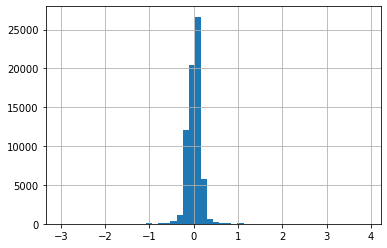

In [13]:
all_runs_to['scoring_ratio'].hist(bins=50)

In [14]:
all_runs_to[(all_runs_to['to']==0)]['scoring_ratio'].describe()

count    60444.000000
mean         0.000512
std          0.174154
min         -3.000000
25%         -0.105263
50%         -0.014493
75%          0.105263
max          3.875000
Name: scoring_ratio, dtype: float64

In [15]:
all_runs_to[(all_runs_to['to']==1)]['scoring_ratio'].describe()

count    7479.000000
mean        0.005625
std         0.114936
min        -2.000000
25%        -0.075906
50%         0.038835
75%         0.082141
max         1.363636
Name: scoring_ratio, dtype: float64

In [16]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)]['scoring_ratio'].describe()

count    6531.000000
mean        0.003172
std         0.115593
min        -2.000000
25%        -0.077586
50%         0.035556
75%         0.081967
max         1.363636
Name: scoring_ratio, dtype: float64

<AxesSubplot:xlabel='run_length', ylabel='next_run_length'>

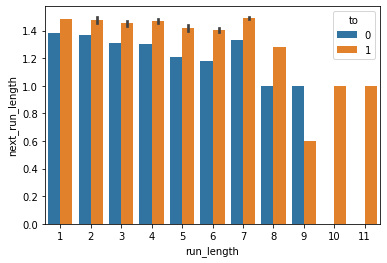

In [27]:
sns.barplot(data = all_runs_to.groupby(['to','changed_run','run_length'],as_index=False)[['next_run_length']].mean(),x='run_length',y='next_run_length',hue='to')

<AxesSubplot:xlabel='run_length', ylabel='next_run_length'>

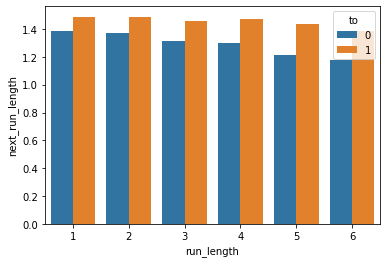

In [29]:
sns.barplot(data=all_runs_to[(all_runs_to['run_length']<7)&(all_runs_to['run_length']<7)].groupby(['to','run_length'])['next_run_length'].mean().reset_index(),
            x='run_length',y='next_run_length',hue='to')

In [30]:
all_runs_to[all_runs_to['to']==1]['changed_run'].value_counts(normalize=True)

1    0.668405
0    0.331595
Name: changed_run, dtype: float64

In [31]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)]['changed_run'].value_counts(normalize=True)


1    0.660695
0    0.339305
Name: changed_run, dtype: float64

In [32]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&
            (all_runs_to['avg_opponent_run_length']>0)&
            (all_runs_to['avg_own_run_length']>0)][['avg_opponent_run_length','avg_own_run_length']].describe()

,avg_opponent_run_length,avg_own_run_length
count,6060.000000,6060.000000
mean,1.433578,1.462186
std,0.473360,0.511684
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.333333,1.333333
75%,1.600000,1.666667
max,6.000000,6.000000


In [33]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['next_run_length'].describe()

count    4315.000000
mean        1.482966
std         0.869498
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: next_run_length, dtype: float64

In [34]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)]['run_length_continued'].describe()

count    2216.000000
mean        1.510379
std         0.846654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: run_length_continued, dtype: float64

In [35]:
all_runs_to[(all_runs_to['to']!=1)&(all_runs_to['to_non_run']!=1)&(all_runs_to['changed_run']!=1)]['next_run_length'].describe()

count    60444.000000
mean         1.375141
std          0.879526
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: next_run_length, dtype: float64

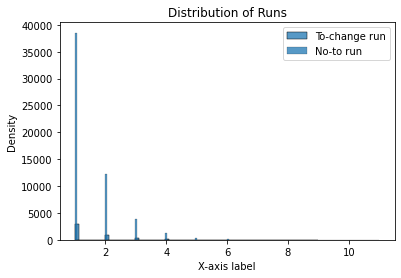

In [36]:
# Plot KDE for Series 1
sns.histplot(data=all_runs_to[(all_runs_to['to'] == 1) & 
                        (all_runs_to['to_non_run'] == 1) & 
                        (all_runs_to['changed_run'] == 1)&(all_runs_to['next_run_length']>0)]['next_run_length'], 
            label='To-change run')

# Plot KDE for Series 2
# sns.histplot(all_runs_to[(all_runs_to['to'] == 1) & 
#                         (all_runs_to['to_non_run'] == 1) & 
#                         (all_runs_to['changed_run'] == 0)]['run_length_continued'], 
#             label='To-no-change run')

# Plot KDE for Series 3
sns.histplot(data=all_runs_to[(all_runs_to['to'] != 1) & 
                        (all_runs_to['to_non_run'] != 1) & 
                        (all_runs_to['changed_run'] != 1)&(all_runs_to['next_run_length']>0)]['next_run_length'], 
            label='No-to run')

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Density')
plt.title('Distribution of Runs')

# Show the legend
plt.legend()

# Display the plot
plt.show()


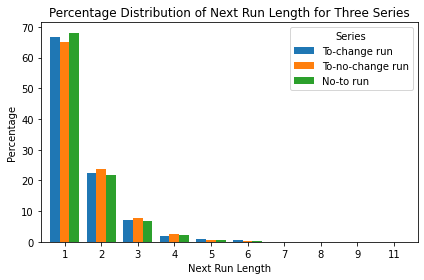

In [37]:
# Define a function to calculate percentages
def calculate_percentages(series):
    counts = series.value_counts().sort_index()
    percentages = (counts / counts.sum()) * 100
    return percentages

# Filter and calculate percentages for each series
series1 = all_runs_to[(all_runs_to['to'] == 1) & 
                      (all_runs_to['to_non_run'] == 1) & 
                      (all_runs_to['changed_run'] == 1)&(all_runs_to['next_run_length']>0)]['next_run_length']
series1_percentages = calculate_percentages(series1)

series2 = all_runs_to[(all_runs_to['to'] == 1) & 
                      (all_runs_to['to_non_run'] == 1) & 
                      (all_runs_to['changed_run'] == 0)]['run_length_continued']
series2_percentages = calculate_percentages(series2)

series3 = all_runs_to[(all_runs_to['to'] != 1) & 
                      (all_runs_to['to_non_run'] != 1) & 
                      (all_runs_to['changed_run'] != 1)&(all_runs_to['next_run_length']>0)]['next_run_length']
series3_percentages = calculate_percentages(series3)

# Combine the series into a DataFrame for easier plotting
percentages_df = pd.DataFrame({
    'To-change run': series1_percentages,
    'To-no-change run': series2_percentages,
    'No-to run': series3_percentages
}).fillna(0)  # Fill NaNs with zeros for values that don't appear in some series

# Plot the bar chart
percentages_df.plot(kind='bar', width=0.8)

# Add labels and title
plt.xlabel('Next Run Length')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Next Run Length for Three Series')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Series')

# Display the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [38]:
series1.mean()

1.4950934579439252

In [39]:
series2.mean()

1.510379061371841

In [40]:
series3.mean()

1.4685595151857807

In [41]:
percentages_df

,To-change run,To-no-change run,No-to run
1,66.728972,65.162455,68.089542
2,22.570093,23.646209,21.790138
3,7.242991,7.671480,6.811074
4,2.032710,2.481949,2.268591
5,0.887850,0.722022,0.722628
6,0.467290,0.225632,0.215552
7,0.046729,0.045126,0.063605
8,0.000000,0.045126,0.026502
9,0.023364,0.000000,0.010601
11,0.000000,0.000000,0.001767


# Team analysis

In [42]:
team_stats_df = leaguedashteamstats.LeagueDashTeamStats(season='2023-24').get_data_frames()[0]

In [43]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['run_length'].describe()

count    4315.000000
mean        2.042642
std         0.956174
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: run_length, dtype: float64

In [44]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)]['run_length_continued'].describe()

count    2216.000000
mean        1.510379
std         0.846654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: run_length_continued, dtype: float64

In [45]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['next_run_length'].describe()

count    4315.000000
mean        1.482966
std         0.869498
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: next_run_length, dtype: float64

In [46]:
all_runs_to[(all_runs_to['to']==0)]['run_length'].describe()

count    60444.000000
mean         1.350936
std          0.660563
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: run_length, dtype: float64

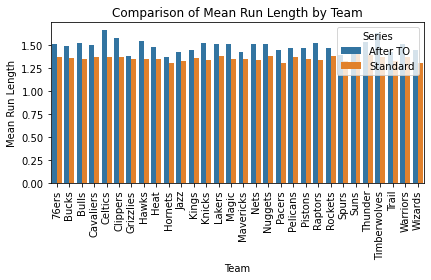

In [47]:
after_to_series = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team')['next_run_length'].mean()
std_series = all_runs_to[(all_runs_to['to']==0)].groupby('run_team')['run_length'].mean()
# Convert series to DataFrames and align the indices
df1 = after_to_series.rename('After TO').reset_index()
df2 = std_series.rename('Standard').reset_index()

# Standardize column names to merge them
df1.columns = ['Team', 'After TO']
df2.columns = ['Team', 'Standard']

# Merge the two DataFrames on 'Team'
merged_df = pd.merge(df1, df2, on='Team', how='outer').fillna(0)

# Melt the DataFrame for easier plotting with Seaborn
melted_df = pd.melt(merged_df, id_vars='Team', value_vars=['After TO', 'Standard'], 
                    var_name='Series', value_name='Mean Run Length')

# Plotting
sns.barplot(data=melted_df, x='Team', y='Mean Run Length', hue='Series')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Team')
plt.ylabel('Mean Run Length')
plt.title('Comparison of Mean Run Length by Team')

# Show the plot
plt.tight_layout()
plt.show()

In [48]:
colors_df = pd.read_csv('colors_nba_teams.csv')

In [49]:
colors_df['Color 1'] = colors_df['Color 1'].str.split('#',expand=True)[1]
colors_df['Color 1'] = [f"#{x}" for x in colors_df['Color 1']]

In [50]:
colors_df['Team'] = [x[-1] for x in colors_df['NBA Team Name'].str.split(' ')]

In [51]:
team_stats_df['Team'] = [x[-1] for x in team_stats_df['TEAM_NAME'].str.split(' ')]

In [52]:
team_stats_df = team_stats_df.merge(colors_df[['Team','Color 1']],on='Team',how='left')

In [53]:
melted_df = melted_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],on='Team',how='left')

In [54]:
melted_df.loc[melted_df['Team']=='Trail',['W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['W','L','W_PCT','Color 1']].values

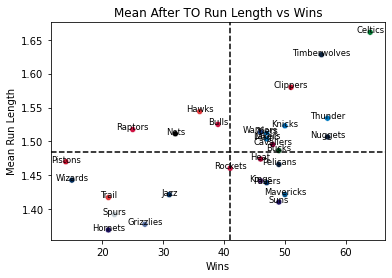

In [55]:
# Filter the DataFrame for 'After TO' series
after_to_df = melted_df[melted_df['Series'] == 'After TO']

# Create a dictionary mapping each team to its color
team_colors = dict(zip(after_to_df['Team'], after_to_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=after_to_df, x='W', y='Mean Run Length', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(after_to_df['Mean Run Length'].mean(), color='black', linestyle='--')
plt.axvline(after_to_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Mean After TO Run Length vs Wins')
plt.xlabel('Wins')
plt.ylabel('Mean Run Length')

# Adding legend manually on top of each dot
for line in range(0, after_to_df.shape[0]):
     plt.text(after_to_df.W.iloc[line], after_to_df['Mean Run Length'].iloc[line], 
     after_to_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()

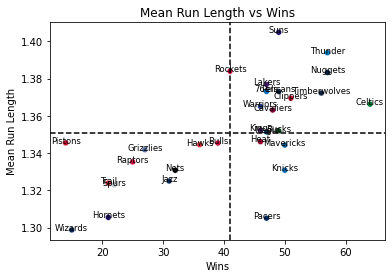

In [56]:
# Filter the DataFrame for 'After TO' series
std_df = melted_df[melted_df['Series'] == 'Standard']

# Create a dictionary mapping each team to its color
team_colors = dict(zip(std_df['Team'], std_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=std_df, x='W', y='Mean Run Length', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(std_df['Mean Run Length'].mean(), color='black', linestyle='--')
plt.axvline(std_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Mean Run Length vs Wins')
plt.xlabel('Wins')
plt.ylabel('Mean Run Length')

# Adding legend manually on top of each dot
for line in range(0, std_df.shape[0]):
     plt.text(std_df.W.iloc[line], std_df['Mean Run Length'].iloc[line], 
     std_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()

<AxesSubplot:>

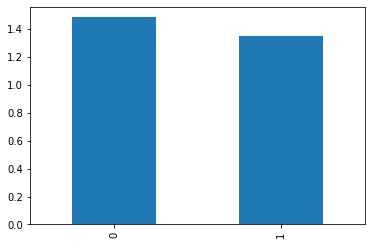

In [57]:
pd.Series([after_to_series.mean(),std_series.mean()]).plot(kind='bar')

In [58]:
merged_df['pct_diff'] = (merged_df['After TO']-merged_df['Standard'])/merged_df['Standard']

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

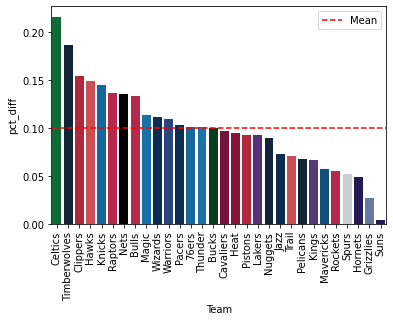

In [60]:
sns.barplot(data=merged_df.sort_values('pct_diff',ascending=False),x='Team',y='pct_diff',color='red',palette=team_colors)
plt.xticks(rotation=90)
plt.axhline(y=merged_df['pct_diff'].mean(),color='red',label='Mean',linestyle='--')
plt.legend()
plt.tight_layout

<AxesSubplot:title={'center':'Average Own Next Run Length for To-change runs'}, xlabel='to_team'>

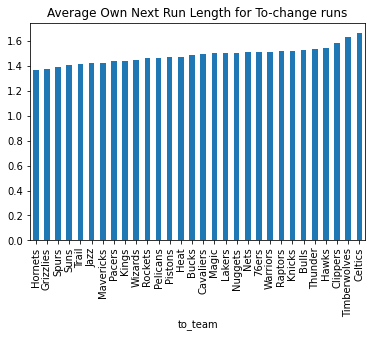

In [61]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team')['next_run_length'].mean().sort_values().plot(kind='bar',title='Average Own Next Run Length for To-change runs')

<AxesSubplot:title={'center':'After to, no change run length'}, xlabel='to_team'>

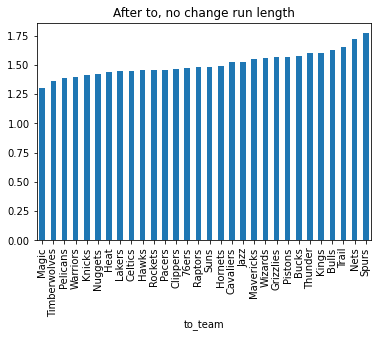

In [62]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team')['run_length_continued'].mean().sort_values().plot(kind='bar',title='After to, no change run length')

In [63]:
to_non_change_df = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team',as_index = False)['run_length_continued'].mean()

In [64]:
to_non_change_df = to_non_change_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],left_on='to_team',right_on='Team',how='left')
to_non_change_df.loc[to_non_change_df['to_team']=='Trail',['Team','W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['Team','W','L','W_PCT','Color 1']].values

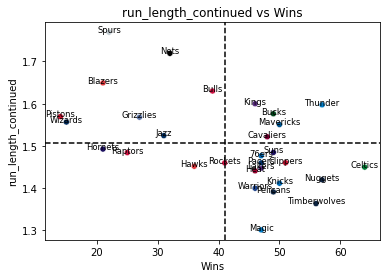

In [65]:
# Create a dictionary mapping each team to its color
team_colors = dict(zip(to_non_change_df['Team'], to_non_change_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=to_non_change_df, x='W', y='run_length_continued', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(to_non_change_df['run_length_continued'].mean(), color='black', linestyle='--')
plt.axvline(to_non_change_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('run_length_continued vs Wins')
plt.xlabel('Wins')
plt.ylabel('run_length_continued')

# Adding legend manually on top of each dot
for line in range(0, to_non_change_df.shape[0]):
     plt.text(to_non_change_df.W.iloc[line], to_non_change_df['run_length_continued'].iloc[line], 
     to_non_change_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()        


In [83]:
to_changes_run_df = pd.concat([all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team').size(),all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team').size()],
          axis=1)

In [84]:
to_changes_run_df['total'] = to_changes_run_df[0] + to_changes_run_df[1]
to_changes_run_df[0] = to_changes_run_df[0]/to_changes_run_df['total']
to_changes_run_df[1] = to_changes_run_df[1]/to_changes_run_df['total']
to_changes_run_df.drop('total',axis=1,inplace=True)
to_changes_run_df.reset_index(inplace=True)

In [85]:
to_changes_run_df = to_changes_run_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],left_on='to_team',right_on='Team',how='left')
to_changes_run_df.loc[to_changes_run_df['to_team']=='Trail',['Team','W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['Team','W','L','W_PCT','Color 1']].values

In [86]:
to_changes_run_df

,to_team,0,1,Team,W,L,W_PCT,Color 1
0,76ers,0.661458,0.338542,76ers,47.0,35.0,0.573,#006BB6
1,Bucks,0.717703,0.282297,Bucks,49.0,33.0,0.598,#00471B
2,Bulls,0.655660,0.344340,Bulls,39.0,43.0,0.476,#CE1141
3,Cavaliers,0.612360,0.387640,Cavaliers,48.0,34.0,0.585,#860038
4,Celtics,0.662921,0.337079,Celtics,64.0,18.0,0.780,#007A33
5,Clippers,0.728448,0.271552,Clippers,51.0,31.0,0.622,#C8102E
6,Grizzlies,0.661538,0.338462,Grizzlies,27.0,55.0,0.329,#5D76A9
7,Hawks,0.650718,0.349282,Hawks,36.0,46.0,0.439,#E03A3E
8,Heat,0.630435,0.369565,Heat,46.0,36.0,0.561,#98002E
9,Hornets,0.666667,0.333333,Hornets,21.0,61.0,0.256,#1D1160


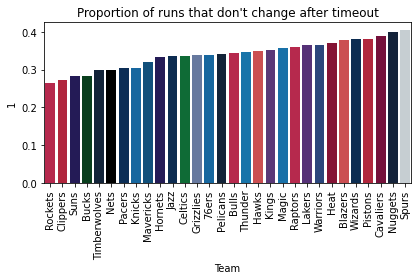

In [88]:
sns.barplot(data = to_changes_run_df.sort_values(1),x='Team',y=1,palette=team_colors)
plt.title("Proportion of runs that don't change after timeout")
plt.xticks(rotation=90)
# Adjust layout to prevent overlap
plt.tight_layout()

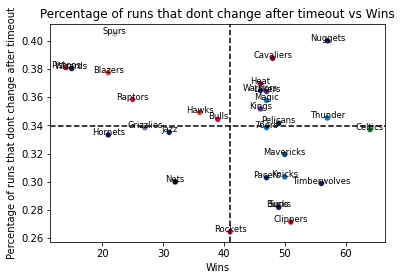

In [92]:
# Create the scatter plot
sns.scatterplot(data=to_changes_run_df, x='W', y=1, hue='Team', palette=team_colors, legend=False)
# Add the mean lines
plt.axhline(to_changes_run_df[1].mean(), color='black', linestyle='--')
plt.axvline(to_changes_run_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Percentage of runs that dont change after timeout vs Wins')
plt.xlabel('Wins')
plt.ylabel('Percentage of runs that dont change after timeout')

# Adding legend manually on top of each dot
for line in range(0, to_changes_run_df.shape[0]):
     plt.text(to_changes_run_df.W.iloc[line], to_changes_run_df[1].iloc[line], 
     to_changes_run_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()   

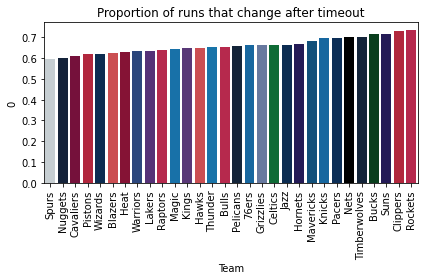

In [93]:
sns.barplot(data = to_changes_run_df.sort_values(0),x='Team',y=0,palette=team_colors)
plt.title("Proportion of runs that change after timeout")
plt.xticks(rotation=90)
# Adjust layout to prevent overlap
plt.tight_layout()

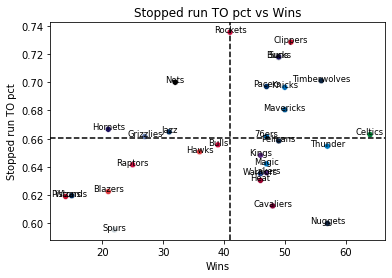

In [94]:
# Create the scatter plot
sns.scatterplot(data=to_changes_run_df, x='W', y=0, hue='Team', palette=team_colors, legend=False)
# Add the mean lines
plt.axhline(to_changes_run_df[0].mean(), color='black', linestyle='--')
plt.axvline(to_changes_run_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Stopped run TO pct vs Wins')
plt.xlabel('Wins')
plt.ylabel('Stopped run TO pct')

# Adding legend manually on top of each dot
for line in range(0, to_changes_run_df.shape[0]):
     plt.text(to_changes_run_df.W.iloc[line], to_changes_run_df[0].iloc[line], 
     to_changes_run_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()   

In [95]:
non_run_to_df_means = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby('to_team')[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

In [96]:
team_colors.update({'Trail': '#E03A3E'})

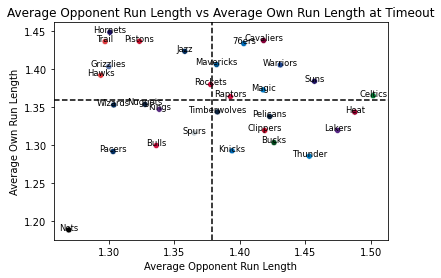

In [97]:
sns.scatterplot(data=non_run_to_df_means, x='avg_opponent_run_length', y='avg_own_run_length',hue='to_team', palette=team_colors, legend=False)
plt.axhline(non_run_to_df_means['avg_own_run_length'].mean(), color='black', linestyle='--')
plt.axvline(non_run_to_df_means['avg_opponent_run_length'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Average Opponent Run Length vs Average Own Run Length at Timeout')
plt.xlabel('Average Opponent Run Length')
plt.ylabel('Average Own Run Length')

# Adding legend manually on top of each dot
for line in range(0, non_run_to_df_means.shape[0]):
     plt.text(non_run_to_df_means['avg_opponent_run_length'].iloc[line], non_run_to_df_means['avg_own_run_length'].iloc[line], 
     non_run_to_df_means['to_team'].iloc[line], horizontalalignment='center', size='small', color='black')

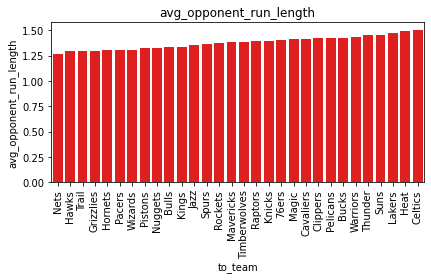

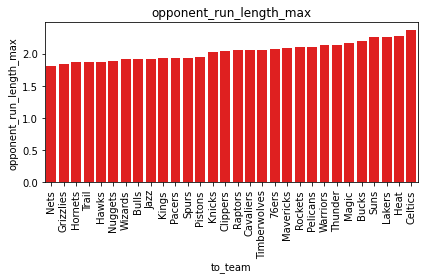

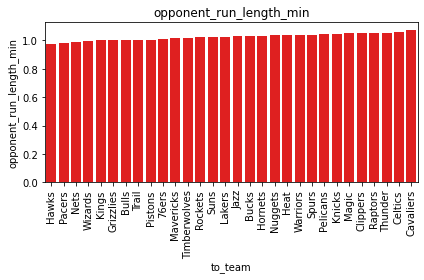

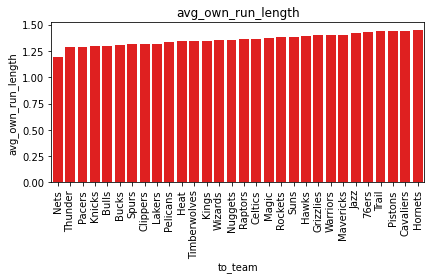

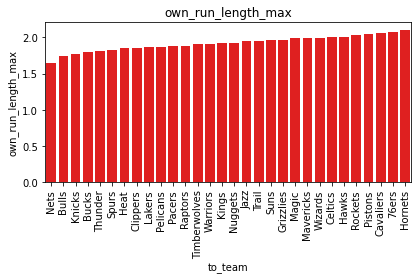

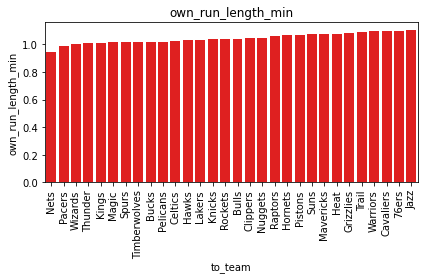

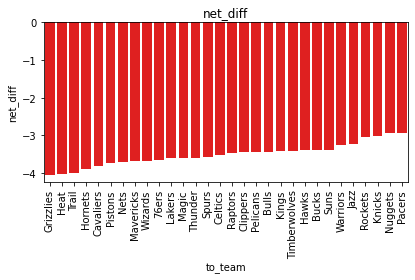

In [99]:
for y in non_run_to_df_means.columns[1:]:
    sns.barplot(data=non_run_to_df_means.sort_values(by=y),x='to_team',y=y,color='red')
    plt.title(f'{y}')
    plt.xticks(rotation=90)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [100]:
to_changed_run = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['to_team','changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

In [101]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

,changed_run,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,net_diff
0,0,1.372601,2.008574,1.019856,1.367306,1.916968,1.055054,-4.231949
1,1,1.377474,2.034994,1.027115,1.351773,1.914716,1.035921,-3.113094


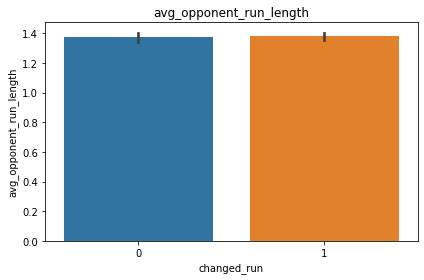

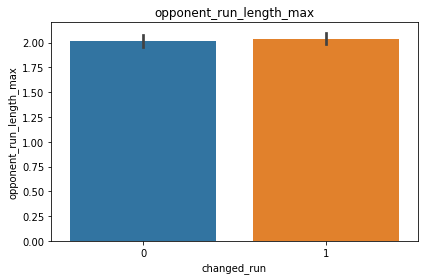

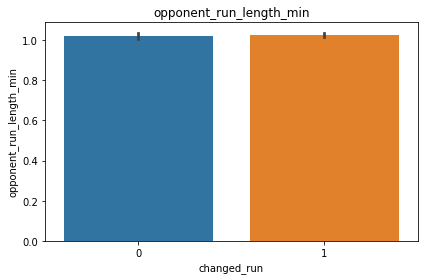

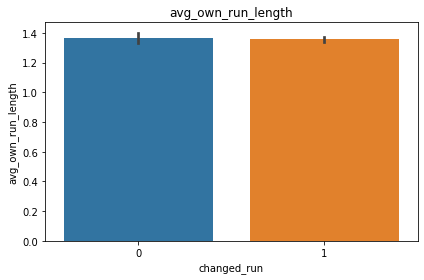

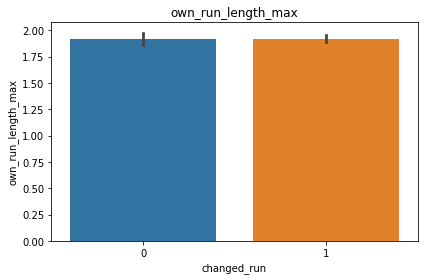

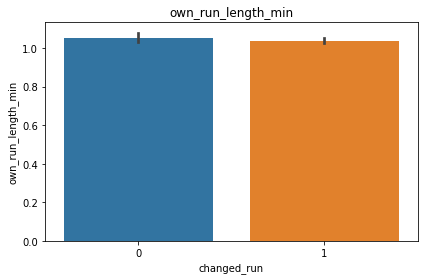

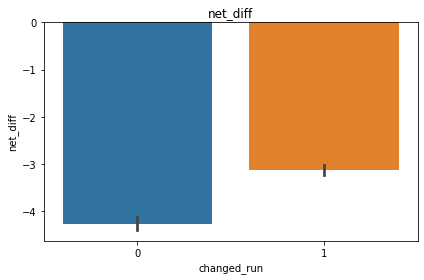

In [102]:
for col in all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index().columns[1:]:
       sns.barplot(data=to_changed_run,x='changed_run',y=col)
       plt.title(f'{col}')
       plt.tight_layout()
       plt.show()

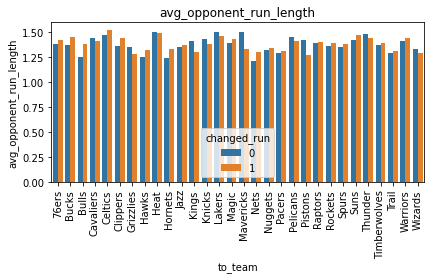

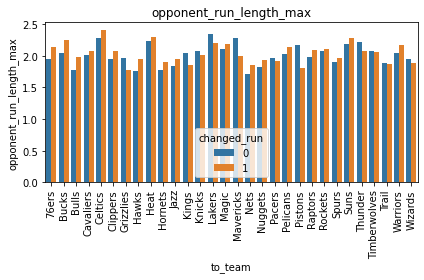

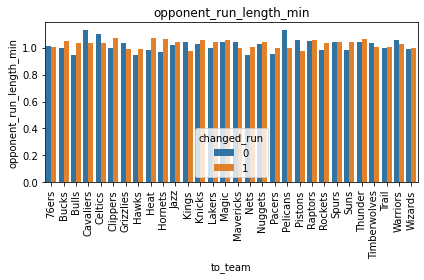

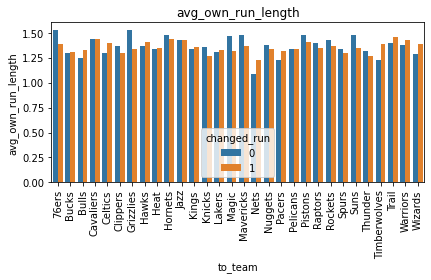

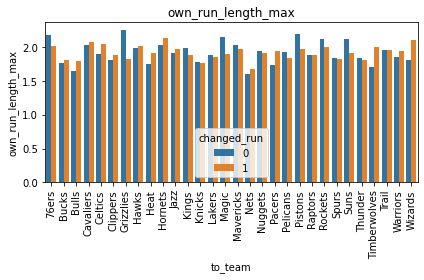

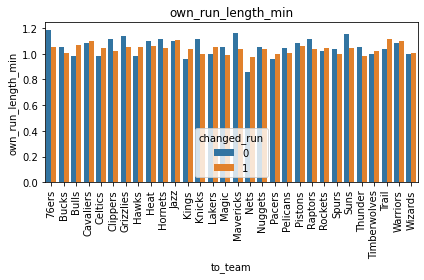

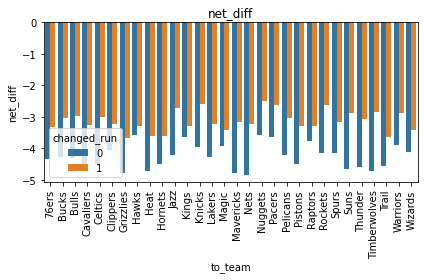

In [103]:
for col in to_changed_run.columns[2:]:
    sns.barplot(data=to_changed_run,x='to_team',y=col,hue='changed_run')
    plt.xticks(rotation=90)
    plt.title(col)
    plt.tight_layout()
    plt.show()

# Modelling

In [10]:
df_analysis = all_runs_to.copy()

In [11]:
df_analysis[(df_analysis['home_to'] == 1)&(df_analysis['next_3_avg_scoring_ratio'].isna()==False)
            &(df_analysis['to_non_run']==1)][[x for x in df_analysis.columns if 'scoring_ratio' in x]].sort_values('next_3_avg_scoring_ratio',ascending=False).head(25).mean()

scoring_ratio              -0.156714
avg_2_scoring_ratio        -0.025740
avg_3_scoring_ratio        -0.051783
avg_4_scoring_ratio        -0.016470
avg_5_scoring_ratio        -0.037439
next_1_avg_scoring_ratio    0.508754
next_2_avg_scoring_ratio    0.170589
next_3_avg_scoring_ratio    0.254826
next_4_avg_scoring_ratio    0.160302
next_5_avg_scoring_ratio    0.146317
dtype: float64

In [12]:
df_analysis[(df_analysis['home_to'] == 1)&(df_analysis['next_3_avg_scoring_ratio'].isna()==False)
            &(df_analysis['to_non_run']==1)][[x for x in df_analysis.columns if 'scoring_ratio' in x]].sort_values('next_3_avg_scoring_ratio').head(25).mean()

scoring_ratio              -0.091783
avg_2_scoring_ratio         0.012249
avg_3_scoring_ratio        -0.031336
avg_4_scoring_ratio         0.000730
avg_5_scoring_ratio        -0.025162
next_1_avg_scoring_ratio    0.034350
next_2_avg_scoring_ratio   -0.133772
next_3_avg_scoring_ratio   -0.112422
next_4_avg_scoring_ratio   -0.085142
next_5_avg_scoring_ratio   -0.071832
dtype: float64

In [13]:
model_cols = [x for x in df_analysis.columns if 'next' not in x and 'scoring_ratio' in x]
model_cols_2 = ['avg_opponent_run_length', 'opponent_run_length_max',
       'opponent_run_length_min', 'avg_own_run_length', 'own_run_length_max',
       'own_run_length_min', 'net_diff','next_3_avg_scoring_ratio','previous_run_time', 'last_run_time', 'time_spent_run', 'to_time']
model_cols = model_cols + model_cols_2

In [14]:
home_df_to = df_analysis[(df_analysis['to_non_run']==1)][model_cols]

In [15]:
X = home_df_to.drop('next_3_avg_scoring_ratio',axis=1)

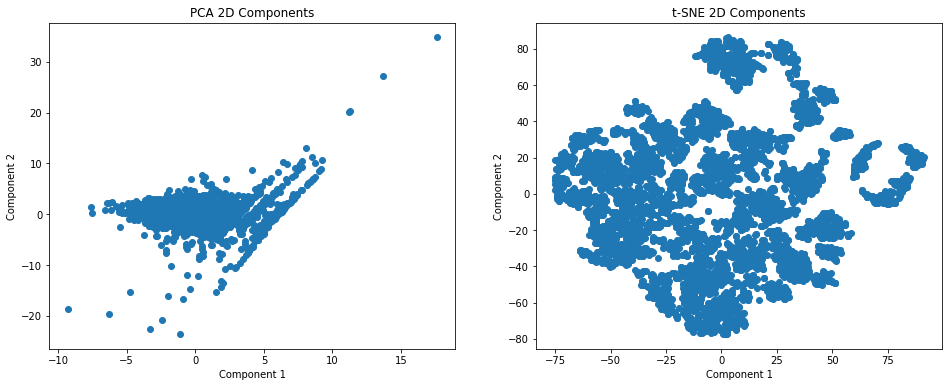

Correlation between original distances and PCA-reduced distances: 0.8664
Correlation between original distances and t-SNE-reduced distances: 0.3884
PCA Explained Variance Ratio: [0.26730956 0.21919129]
Total Explained Variance by PCA: 0.48650084958019024


In [19]:
# Ensure X is a DataFrame
if not isinstance(X, pd.DataFrame):
    raise ValueError("Input data X should be a Pandas DataFrame")

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_components = tsne.fit_transform(X_scaled)

# Visualize PCA vs t-SNE
def plot_comparison(method1_name, components1, method2_name, components2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].scatter(components1[:, 0], components1[:, 1])
    axs[0].set_title(f'{method1_name} 2D Components')
    axs[0].set_xlabel('Component 1')
    axs[0].set_ylabel('Component 2')

    axs[1].scatter(components2[:, 0], components2[:, 1])
    axs[1].set_title(f'{method2_name} 2D Components')
    axs[1].set_xlabel('Component 1')
    axs[1].set_ylabel('Component 2')

    plt.show()

plot_comparison('PCA', pca_components, 't-SNE', tsne_components)

# Metric Preservation - Comparing Pairwise Distances
from scipy.spatial.distance import pdist, squareform

# Original pairwise distances
original_distances = squareform(pdist(X_scaled))

# PCA pairwise distances
pca_distances = squareform(pdist(pca_components))

# t-SNE pairwise distances
tsne_distances = squareform(pdist(tsne_components))

# Correlation of distances
pca_correlation = np.corrcoef(original_distances.ravel(), pca_distances.ravel())[0, 1]
tsne_correlation = np.corrcoef(original_distances.ravel(), tsne_distances.ravel())[0, 1]

print(f"Correlation between original distances and PCA-reduced distances: {pca_correlation:.4f}")
print(f"Correlation between original distances and t-SNE-reduced distances: {tsne_correlation:.4f}")

# Compare Explained Variance for PCA
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance by PCA: {explained_variance.sum()}")

In [18]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

In [19]:
pca_components_df = pd.DataFrame(pca_components,columns=['PC1','PC2','PC3'])
pca_components_df['home_to'] = df_analysis[(df_analysis['to_non_run']==1)]['home_to'].values

In [20]:
pca_components_df['next_3_avg_scoring_ratio'] = df_analysis[(df_analysis['to_non_run']==1)]['next_3_avg_scoring_ratio'].values

In [21]:
X_train,X_test,y_train,y_test =  train_test_split(pca_components_df.drop('next_3_avg_scoring_ratio',axis=1),
                                                  pca_components_df['next_3_avg_scoring_ratio'])

In [217]:
# Define the XGBRegressor model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define the hyperparameter distribution for Randomized Search
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 11, 1),
    'min_child_weight': np.arange(1, 11, 1),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Choose either Grid Search or Randomized Search
# Here we use Randomized Search for a broader exploration
search = random_search

# Fit the search to the data
search.fit(X_train, y_train)

# Best parameters found by the search
best_params = search.best_params_
print(f"Best parameters found: {best_params}")

# Best estimator (model) from the search
best_xgb_model = search.best_estimator_

# Evaluate the model on the test set
y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on test set: {mse}")
print(f"R2 Score on test set: {r2}")

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found: {'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Mean Squared Error on test set: 0.0022356960840719795
R2 Score on test set: 0.34103572359062795


In [20]:
best_params = {'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
xgb = XGBRegressor(**best_params)
lr = LinearRegression()
xgb.fit(X_train,y_train)
lr.fit(X_train,y_train) 
print(mean_squared_error(y_test.values,xgb.predict(X_test)))
print(mean_squared_error(y_test.values,lr.predict(X_test)))
print(r2_score(y_test.values,xgb.predict(X_test)))
print(r2_score(y_test.values,lr.predict(X_test)))

0.0023851623722726052
0.0023631448465251483
0.3317633400806893
0.3379318584323978


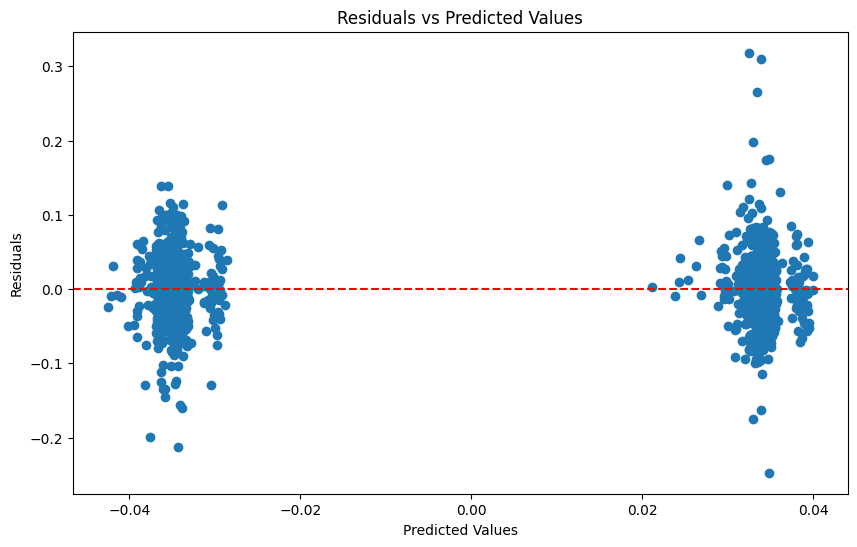

Durbin-Watson statistic: 1.9937816354692643


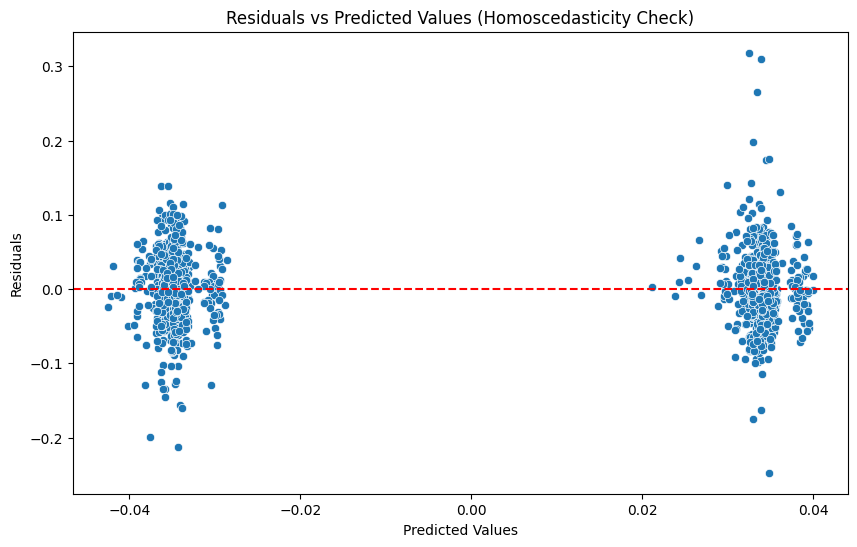

{'Lagrange multiplier statistic': 30.867264631811775, 'p-value': 3.2583086050745524e-06, 'f-value': 7.841408160392077, 'f p-value': 2.9396987153401634e-06}
   feature       VIF
0      PC1  1.001681
1      PC2  1.048751
2      PC3  1.000099
3  home_to  1.047210


<Figure size 1000x600 with 0 Axes>

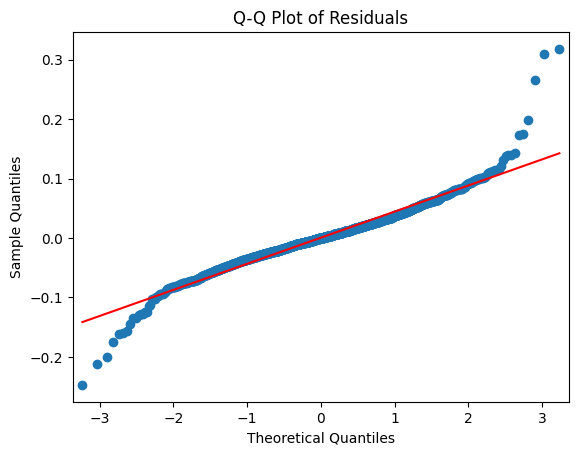

Shapiro-Wilk Test: Stat=0.9491896544260433, p-value=2.49722293095328e-23
Kolmogorov-Smirnov Test: Stat=0.44837438004704366, p-value=5.192788241750343e-300
Mean Squared Error: 0.001931346962018829
R2 Score: 0.38144435338361593


In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, kstest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming pca_components_df is your DataFrame with PCA components and the target variable
# X_train, X_test, y_train, y_test = train_test_split(...)

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Residuals
residuals = y_test - y_pred

# 1. Linearity
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# 2. Independence - Durbin-Watson Test
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

# 3. Homoscedasticity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Homoscedasticity Check)')
plt.show()

# Breusch-Pagan Test for Homoscedasticity
exog = sm.add_constant(X_test)
bp_test = het_breuschpagan(residuals, exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))

# 4. No Perfect Multicollinearity
# VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

# 5. Normality
# Q-Q Plot
plt.figure(figsize=(10, 6))
qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(residuals)
print(f'Shapiro-Wilk Test: Stat={shapiro_stat}, p-value={shapiro_p}')

# Kolmogorov-Smirnov Test
ks_stat, ks_p = kstest(residuals, 'norm')
print(f'Kolmogorov-Smirnov Test: Stat={ks_stat}, p-value={ks_p}')

# Evaluate the model performance
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

In [22]:
import flexcode
from flexcode.regression_models import XGBoost

# Parameterize and fit the FlexCode model
model = flexcode.FlexCodeModel(XGBoost, max_basis=70, basis_system="cosine",
                               regression_params={"n_estimators": 100,
                                                  'learning_rate': 1,
                                                  "max_depth": 5})
model.fit(X_train.values, y_train.values)

#Predict conditional densities and y grid using the model for validation set
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

# Define function to calculate the expectation (mean) and standard deviation of the estimated distribution
def conditional_mean_std(cde, y_grid):
    mean_est = np.sum(y_grid * cde) / np.sum(cde)  # Mean as the weighted average
    std_est = np.sqrt(np.sum(((y_grid - mean_est) ** 2) * cde) / np.sum(cde))  # Std deviation
    return mean_est, std_est

# Calculate metrics
log_likelihoods = []
rmse_means = []
rmse_stds = []

# Iterate over validation set
for i in range(len(X_test)):
    y_value = y_test.values[i]
    cde = cdes[i]
    
    # Calculate conditional mean and standard deviation for the estimated distribution
    mean_est, std_est = conditional_mean_std(cde, y_grid_flexcode)
    
    # Calculate log-likelihood
    log_likelihood = np.log(np.interp(y_value, y_grid_flexcode, cde, left=0, right=0))
    log_likelihoods.append(log_likelihood)
    
    # Calculate RMSE for mean
    rmse_mean = (y_value - mean_est) ** 2
    rmse_means.append(rmse_mean)
    
    # Calculate RMSE for standard deviation
    rmse_std = ((abs(y_value - mean_est) - std_est) ** 2)
    rmse_stds.append(rmse_std)

# Average log-likelihood
avg_log_likelihood = np.mean(log_likelihoods)

# RMSE for mean
rmse_mean = np.sqrt(np.mean(rmse_means))

# RMSE for standard deviation
rmse_std = np.sqrt(np.mean(rmse_stds))

print("Average Log-Likelihood:", avg_log_likelihood)
print("RMSE for Conditional Mean:", rmse_mean)
print("RMSE for Conditional Standard Deviation:", rmse_std)

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(log_likelihoods, bins=30, alpha=0.5, label='Log-Likelihoods')
ax.axvline(avg_log_likelihood, color='r', linestyle='--', label=f'Avg Log-Likelihood: {avg_log_likelihood:.2f}')
ax.set_title("Log-Likelihood Distribution of Validation Data")
ax.set_xlabel("Log-Likelihood")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

exception calling callback for <Future at 0x295f1f824a8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packages\joblib\parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packages\joblib\parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packages\joblib\parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packages\joblib\parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "c:\Users\isaac\.conda\envs\timeout_analysis\lib\site-packa

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
